##ThinkDSP

This notebook contains solutions to exercises in Chapter 6: Discrete Cosine Transform

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
from __future__ import print_function, division

import thinkdsp
import thinkplot
import thinkstats2

import numpy as np
import scipy.fftpack

import warnings
warnings.filterwarnings('ignore')

import dct

%matplotlib inline

**Exercise:** In this chapter I claim that `analyze1` takes time proportional
to $n^3$ and `analyze2` takes time proportional to $n^2$.  To
see if that's true, run them on a range of input sizes and time
them.  In IPython, you can use the magic command `%timeit`.

If you plot run time versus input size on a log-log scale, you
should get a straight line with slope 3 for  `analyze1` and
slope 2 for `analyze2`.  You also might want to test `dct_iv`
and `scipy.fftpack.dct`.

I'll start with a noise signal and an array of power-of-two sizes

In [2]:
signal = thinkdsp.UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)
noise.ys.shape

(16384,)

In [3]:
ns = 2 ** np.arange(6, 15)
ns

array([   64,   128,   256,   512,  1024,  2048,  4096,  8192, 16384])

The following function takes an array of results from a timing experiment, plots the results, and fits a straight line.

In [4]:
def plot_bests(bests):    
    thinkplot.plot(ns, bests)
    thinkplot.config(xscale='log', yscale='log', legend=False)
    
    x = np.log(ns)
    y = np.log(bests)
    t = scipy.stats.linregress(x,y)
    slope = t[0]

    return slope

Here are the results for `analyze1`.

64
The slowest run took 359.58 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 1: 212 µs per loop
128
The slowest run took 35.29 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 1: 774 µs per loop
256
100 loops, best of 1: 2.79 ms per loop
512
100 loops, best of 1: 12.9 ms per loop
1024
10 loops, best of 1: 53.3 ms per loop
2048
1 loops, best of 1: 251 ms per loop
4096
1 loops, best of 1: 1.31 s per loop
8192
1 loops, best of 1: 8.09 s per loop
16384
1 loops, best of 1: 1min 2s per loop


2.246925851367358

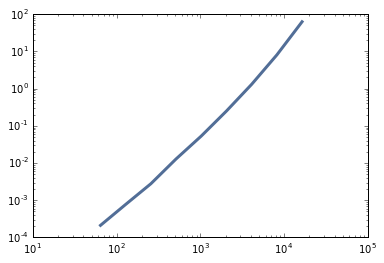

In [5]:
results = []
for N in ns:
    print(N)
    ts = (0.5 + np.arange(N)) / N
    freqs = (0.5 + np.arange(N)) / 2
    ys = noise.ys[:N]
    result = %timeit -r1 -o dct.analyze1(ys, freqs, ts)
    results.append(result)

bests = [result.best for result in results]
plot_bests(bests)

The estimated slope is close to 2, not 3, as expected.  One possibility is that the performance of `np.linalg.solve` is nearly quadratic in this range of array sizes.

The line is curved, which suggests that we have not reached the array size where the runtime shows cubic growth.  With larger array sizes, the estimated slope increases, so maybe it eventually converges on 3.

To finish this exercise, generate similar results for the other functions.

**Exercise:** One of the major applications of the DCT is compression for both sound and images. In its simplest form, DCT-based compression works like this:

1. Break a long signal into segments.
2. Compute the DCT of each segment.
3. Identify frequency components with amplitudes so low they are inaudible, and remove them. Store only the frequencies and amplitudes that remain.
4. To play back the signal, load the frequencies and amplitudes for each segment and apply the inverse DCT.

Implement a version of this algorithm and apply it to a recording of music or speech. How many components can you eliminate before the difference is perceptible?

`thinkdsp` provides a class, `Dct` that is similar to a `Spectrum`, but which uses DCT instead of FFT.

As an example, I'll use a recording of a saxophone:

In [6]:
wave = thinkdsp.read_wave('100475__iluppai__saxophone-weep.wav')
wave.make_audio()

Here's a short segment:

In [7]:
segment = wave.segment(start=1.2, duration=0.5)
segment.normalize()
segment.make_audio()

And here's the DCT of that segment:

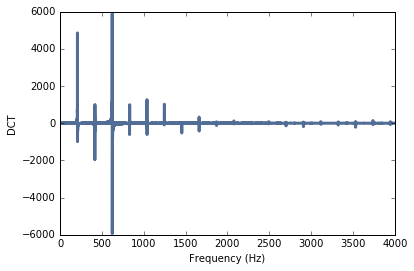

In [8]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
thinkplot.config(xlabel='Frequency (Hz)', ylabel='DCT')

There are only a few harmonics with substantial amplitude, and many entries near zero.

You might want to write a function that takes a DCT and sets elements below some threshold to 0.  Test it with a short segment.

To compress a longer segment, we can make a DCT spectrogram.  The following function is similar to `wave.make_spectrogram` except that it uses the DCT.

In [9]:
def make_dct_spectrogram(wave, seg_length):
    """Computes the DCT spectrogram of the wave.

    seg_length: number of samples in each segment

    returns: Spectrogram
    """
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length / 2

    # map from time to Spectrum
    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        # the nominal time for this segment is the midpoint
        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return thinkdsp.Spectrogram(spec_map, seg_length)

To complete this exercise, use this function to make a DCT spectrogram and compress it.  Then you can convert back to a wave using `Spectrogram.make_wave`.